# Question 2

# Q2.1
In this part, you will build a model to forecast the hourly carpark availability in the future
(aggregated across all carparks instead of looking at each carpark individually). Can you
explain why you may want to forecast the carpark availability in the future? Who would
find this information valuable? What can you do if you have a good forecasting model?

Nowadays, there are many developments and applications used to predict future outcomes. Examples include 'weather' app which predicts weather condition in the future that allows people to plan their journey ahead, and earthquake sensor which predicts potential earthquake disaster in the future that allows people to have time to prepare for evacuation. 

Therefore,based on the sucess that these application have made, we may want to forecast the carpark availability in the future as this will be beneficial to different groups of people. For example, for commuters, they will find it easier to plan their routes and schedule ahead of time. For event organiser, they can refer to the future carpark availabity to choose the best venue with high carpark availability for event organization. For carpark developers, they will be able to find out the potential spots with either high usage or low usage of car parks and thus provide a better refinement to these carpark areas. 

With a good forecasting model, we will be able to avoid the timing when there is sever traffic on the road and space constraint in the carpark areas, and also know whether there is a need for upgrade for a particular carpark system.

# Q 2.2

### Data collection

In [23]:
import requests
import json
import pandas as pd
import datetime
# from retry import retry
import time

In [2]:
@retry(tries=3, delay=5)
def getDataAtTimestamp(year, month, day, hour, min_str='01', sec_str = '00'):
    try:
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{min_str.zfill(2)}%3A{sec_str.zfill(2)}'
        t1 = time.time()
        response_API = requests.get(site)
        t2 = time.time()
        response_API.encoding = 'UTF-8'
        raw_data = json.loads(response_API.content)
        t3 = time.time()
        print("req time = ", t2-t1, "json time = ", t3-t2)
        core_list = raw_data['items'][0]['carpark_data']
        return core_list
    except:
        raise Exception()

def json2csv(raw_data, year, month, day, hour, minute):
    header = ['timestamp', 'carpark_number', 'total_lots', 'lots_available', 'lot_type']
    res_df = pd.DataFrame(columns=header)
    timestamp = datetime.datetime(int(year), int(month),int(day))
    timestamp = timestamp.replace(hour=hour, minute=int(minute), second=0)
    for ele in raw_data:
        info = ele['carpark_info'][0]
        res_df = pd.concat([res_df, pd.DataFrame([[timestamp, ele['carpark_number'], info['total_lots'], info['lots_available'], info['lot_type']]], columns=header)])
        # res_df = res_df.append({'timestamp': timestamp, 'carpark_number': ele['carpark_number'], 'total_lots': info['total_lots'], 'lots_available': info['lots_available'], 'lot_type': info['lot_type']}, ignore_index=True)
    return res_df

In [3]:
import threading
class Worker(threading.Thread):
    def __init__(self, year, month, day):
        super().__init__()
        self.year = year
        self.month = month
        self.day = day

    def run(self):
        raw_datalist = []
        minutes = ['00', "15", '30', '45']
        for hour in range(0, 24):
            print(f"start {self.year} {self.month} {self.day} {hour}")
            for mins in minutes:
                try:
                    raw_data = getDataAtTimestamp(self.year, self.month, self.day, str(hour), mins)
                except:
                    print("error in day: " + self.day + " hour: " + str(hour))
                    continue
                raw_df = json2csv(raw_data, self.year, self.month, self.day, hour, mins)
                raw_datalist.append(raw_df)
            print(f"done {self.year} {self.month} {self.day} {hour}")
        raw_datalist = pd.concat(raw_datalist)
        raw_datalist.to_csv(f'./data/{self.year}-{self.month}-{self.day}.csv', index=False)

In [143]:
year = "2022"
month = "8"
workers = []
thread_count = 1
for rg in range(25, 26, thread_count):
    workers = []
    for day in range(rg, rg+thread_count):
        if day > 31:
            continue
        worker = Worker(year, month, str(day))
        worker.start()
        workers.append(worker)
    for worker in workers:
        worker.join()

start 2022 8 25 0
req time =  0.3698699474334717 json time =  2.09808349609375e-05
req time =  0.23649883270263672 json time =  4.887580871582031e-05
req time =  0.23379039764404297 json time =  2.288818359375e-05
error in day: 25 hour: 0
req time =  0.6727001667022705 json time =  0.0032067298889160156
req time =  1.0249099731445312 json time =  0.0038399696350097656
req time =  1.3583002090454102 json time =  0.006147861480712891
done 2022 8 25 0
start 2022 8 25 1
req time =  0.9791460037231445 json time =  0.00725102424621582
req time =  0.9909241199493408 json time =  0.006165027618408203
req time =  0.9117140769958496 json time =  0.003860950469970703
req time =  0.9819140434265137 json time =  0.007375955581665039
done 2022 8 25 1
start 2022 8 25 2
req time =  0.9968438148498535 json time =  0.006234169006347656
req time =  1.1588680744171143 json time =  0.006609201431274414
req time =  1.0754339694976807 json time =  0.002620220184326172
req time =  1.1069660186767578 json time

# 2. Data cleaning

In [24]:
def load_data(month):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, 32):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    print(full_df.shape)
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df
jul = load_data(7)
aug = load_data(8)

(5785166, 5)
(5781908, 5)


In [45]:
rg_jul = pd.Series(pd.date_range(
    '7/1/2022', '8/1/2022', freq='1h', inclusive='left'))
rg_aug = pd.Series(pd.date_range(
    '8/1/2022', '9/1/2022', freq='1h', inclusive='left'))
jul = jul.resample('1h').mean()
jul['available rate'] = jul['lots_available'] / jul['total_lots']

aug = aug.resample('1h').mean()
aug['available rate'] = aug['lots_available'] / aug['total_lots']
print(jul.shape, aug.shape)

display(jul)
display(aug)

(744, 3) (744, 3)


,total_lots,lots_available,available rate
timestamp,,,
2022-07-01 00:00:00,367.245899,172.771013,0.470450
2022-07-01 01:00:00,367.664210,170.280269,0.463141
2022-07-01 02:00:00,367.687127,168.249206,0.457588
2022-07-01 03:00:00,367.795729,168.253845,0.457465
2022-07-01 04:00:00,367.928644,168.423048,0.457760
...,...,...,...
2022-07-31 19:00:00,367.645444,201.401703,0.547815
2022-07-31 20:00:00,367.824689,197.226672,0.536197
2022-07-31 21:00:00,367.562063,191.428789,0.520807


,total_lots,lots_available,available rate
timestamp,,,
2022-08-01 00:00:00,367.477900,174.520406,0.474914
2022-08-01 01:00:00,367.081822,172.206901,0.469124
2022-08-01 02:00:00,367.718663,170.935164,0.464853
2022-08-01 03:00:00,367.770121,170.147997,0.462648
2022-08-01 04:00:00,367.957285,169.941012,0.461850
...,...,...,...
2022-08-31 19:00:00,366.995556,217.564063,0.592825
2022-08-31 20:00:00,366.957471,203.848292,0.555509
2022-08-31 21:00:00,367.173377,195.556713,0.532600


## 2.2 LR model

In [7]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

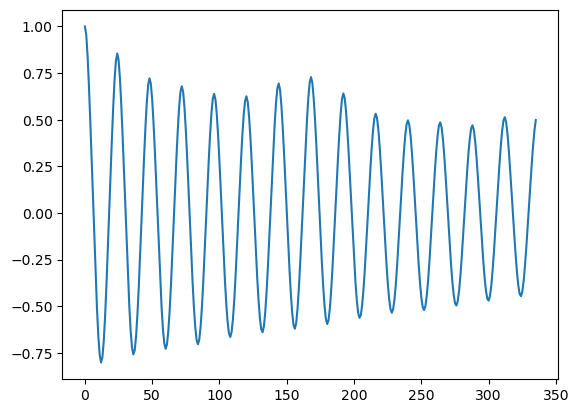

In [8]:
lags = range(24*7*2)
acorr = sm.tsa.acf(jul['available rate'], nlags = len(lags)-1)
plt.plot(lags, acorr)

Taking a few random carparks, we plot the auto correlation for them. We find that there is a strong auto correlation with the  availability at the previous day and the availability at the previous week. Thus, we use the availability in the previous 1 week as input features to predict the availability in the next hour.

In [117]:
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i])
    X = np.array(X)
    Y = np.array(Y)
    print(X.shape, Y.shape)
    return X, Y

In [118]:
"""
Build two models using different features
model1: use the last week's data
model2: use the last days data
"""
feature_len1 = 24*8
X_train1, Y_train1 = prep_train_test(jul, feature_len1)
X_test1, Y_test1 = prep_train_test(aug, feature_len1)

# feature_len2 = 24
# X_train2, Y_train2 = prep_train_test(jul, feature_len2)
# X_test2, Y_test2 = prep_train_test(aug, feature_len2)

(552, 192) (552,)
(552, 192) (552,)


In [119]:
model1 = LinearRegression()
model1.fit(X_train1, Y_train1)
preds1 = model1.predict(X_test1)

# model2 = LinearRegression()
# model2.fit(X_train2, Y_train2)
# preds2 = model2.predict(X_test2)

### Evaluting two LR model performance

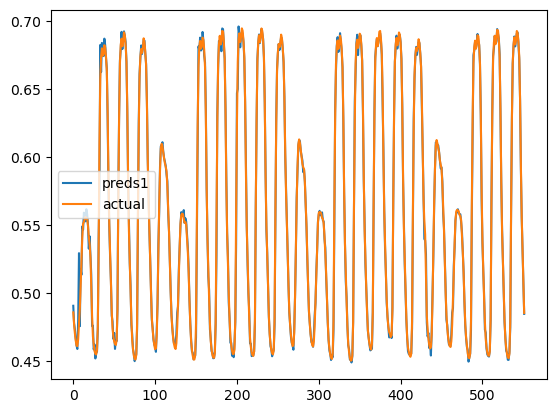

In [120]:
plt.plot(preds1, label='preds1')
# plt.plot(preds2[-len(preds1):], label='preds2')
plt.plot(Y_test1, label='actual')
plt.legend()

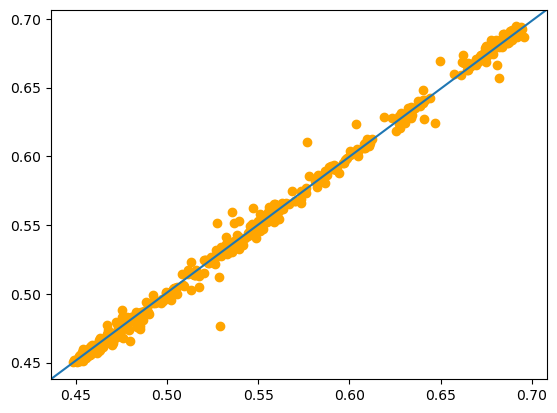

In [121]:
plt.scatter(preds1, Y_test1, label='preds1', color='orange')
# plt.scatter(preds2, Y_test2, label='preds2')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)

In [136]:
m1_r2score = model1.score(X_test1, Y_test1)
rms = np.sqrt(np.mean(np.power((np.array(Y_test1)-np.array(preds1)),2)))
percentage_err = np.mean(np.abs((np.array(Y_test1)-np.array(preds1))/np.array(Y_test1)))*100
print(f"model's r2score: {m1_r2score},\nrms: {rms},\npercentage_err: {percentage_err}")


# rms = mean_squared_error(Y_test1, preds1, squared=False)
# r2Score = r2_score(Y_test1, preds1)
# percentageError = mean_absolute_percentage_error(Y_test1, preds1)
# print(f"model's r2score: {r2Score},\nrms: {rms},\npercentage_err: {percentageError}")

model's r2score: 0.9966407757695142,
rms: 0.0050174958828139,
percentage_err: 0.5211824132081798


<AxesSubplot:>

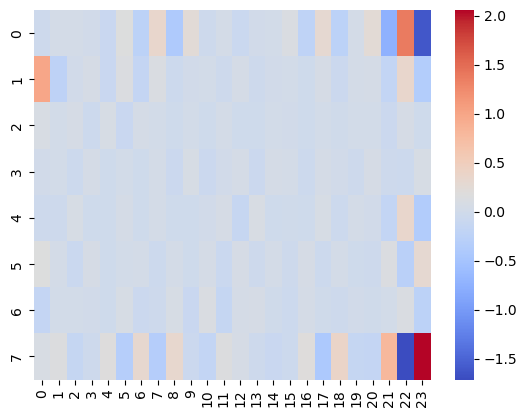

In [15]:
weights = model1.coef_
sns.heatmap(weights.reshape(8,-1), cmap='coolwarm')

Since the model has very high r2 score, it means that the output's variance can be very well explained by the variance in the input features. <br>
The percentage error is 0.5%, which means that the predicted availability is very close to the actual availability. <br>
Looking at the relative importance of all features, we find that there is a strong correlation between the availability few hours ago, 1 day ago and 1 week ago, this corroborates with our initial assumption. <br>
From the scatter plot, we can see that the points are all very close to the line y=x, which means that the predicted availability is very close to the actual availability.<br>
Thus based on above evidences, the model is very good.

# Q2.3
Repeat this for Support Vector Regressor

In [113]:
feature_len1 = 24*8
X_train1, Y_train1 = prep_train_test(jul, feature_len1)
X_test1, Y_test1 = prep_train_test(aug, feature_len1)

(552, 192) (552,)
(552, 192) (552,)


In [114]:
from sklearn.svm import SVR

linear_SVM = SVR(degree=3, C=100, epsilon=.01)
# Train for July
linear_SVM.fit(X_train1, Y_train1)
# Predict for Aug
y_pred_SVR = linear_SVM.predict(X_test1) 

min of y_pred is 0.4457583817283922 max of y_pred is 0.6927510438564182 
min of Y_test1 is 0.4501064176570694 max of Y_test1 is 0.6943731049825416 
min of Y_train1 is 0.4490613244957589 max of Y_train1 is 0.6920485985389758 


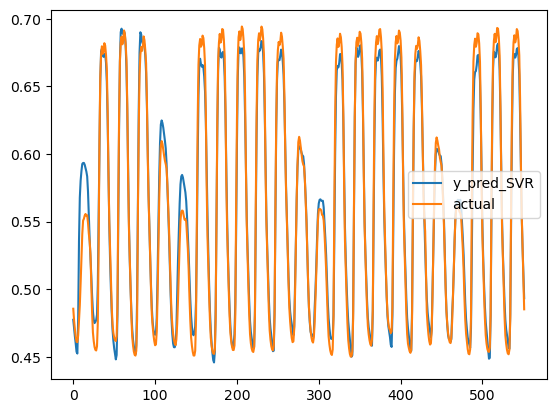

In [115]:
plt.plot(y_pred_SVR, label='y_pred_SVR')
plt.plot(Y_test1, label='actual')
plt.legend()

print(f"min of y_pred is {min(y_pred_SVR)} max of y_pred is {max(y_pred_SVR)} ")
print(f"min of Y_test1 is {min(Y_test1)} max of Y_test1 is {max(Y_test1)} ")
print(f"min of Y_train1 is {min(Y_train1)} max of Y_train1 is {max(Y_train1)} ")

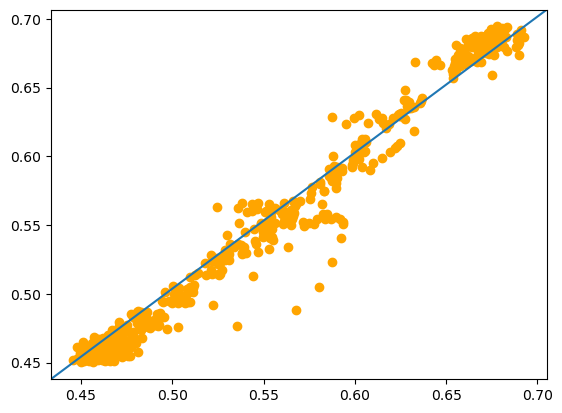

In [97]:
plt.scatter(y_pred_SVR, Y_test1, label='y_pred_SVR', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)

In [139]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

rms = mean_squared_error(Y_test1, y_pred_SVR, squared=False)
r2Score = r2_score(Y_test1, y_pred_SVR)
percentageError = mean_absolute_percentage_error(Y_test1, y_pred_SVR)
print(f"Model's r2score: {r2Score},\nRMS: {rms},\nPercentage Error: {percentageError*100}%")

Model's r2score: 0.976496190645292,
RMS: 0.013272008634431079,
Percentage Error: 1.743433383019374%


# Intepretation of model's performance
The SVR model has a very high R Square value of 0.976 which indicates a good fit between predicted and actual value.

The percentage error at 1.75% means that the predicted values are very close to the actual values.

From these metrics, it can be seen that SVR is a fairly good model for this data distribution.